In [2]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [10]:
#lt = gpd.read_file("/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw")
lt = pd.read_csv("/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw", names =["InterCloud",
                                                                                             "t", 
                                                                                             "lat", 
                                                                                             "lon",
                                                                                             "current_mag", 
                                                                                             "multiplicity_0", 
                                                                                             "accr", 
                                                                                             "error_elps", 
                                                                                             "num_station"])

In [11]:
#?gpd.read_file
#?pd.read_csv

In [16]:
lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))

In [17]:
lt.t = lt.t.astype("datetime64[ns]")

In [19]:
lt = lt[lt.InterCloud == 0]

In [40]:
### Too many points to plot. Cheat by chopping up the lat and lon readings? 

lt.lat_r = lt.lat.round(2)
lt.lon_r = lt.lon.round(2)

In [41]:
sm = lt[["InterCloud", "lat_r", "lon_r"]]
sm = sm.drop_duplicates()
sm = gpd.GeoDataFrame(sm, 
                      geometry=gpd.points_from_xy(sm['lon_r'], sm['lat_r']))

In [45]:
# print(len(lt))
# len(sm)

# sm.set_crs("4326")

2185202


,InterCloud,lat_r,lon_r,geometry
7,0,40.85,-102.069,POINT (-102.06900 40.85000)
8,0,29.19,107.385,POINT (107.38500 29.19000)
9,0,33.32,139.269,POINT (139.26900 33.32000)
32,0,36.77,31.573,POINT (31.57300 36.77000)
37,0,26.41,68.881,POINT (68.88100 26.41000)
...,...,...,...,...
7449519,0,17.03,120.451,POINT (120.45100 17.03000)
7449520,0,-23.69,-56.370,POINT (-56.37000 -23.69000)
7449521,0,25.92,-80.308,POINT (-80.30800 25.92000)
7449522,0,28.13,-68.200,POINT (-68.20000 28.13000)


In [54]:
smol = sm.geometry.sample(100)
smol = smol.set_crs("epsg:4326")

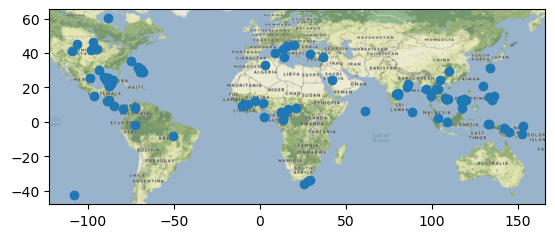

In [55]:

# plt.figure()
# ax = plt.subplot()
# plot = smol.plot(ax = ax)
# cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False) 

In [2]:
### Subset to canada, using our boreal bbox
from shapely.geometry import box

    
    
    

CA_bbox = box(-169, 44, -48, 75)
lt = lt.set_crs("epsg:4326")

smol = lt.clip(CA_bbox)

NameError: name 'lt' is not defined

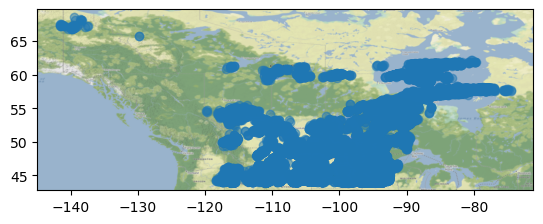

In [68]:
smol = smol.set_crs("epsg:4326")

plt.figure()
ax = plt.subplot()
plot = smol.plot(ax = ax, alpha=0.2)
cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False) ## Projection issues??

In [67]:
smol.t = smol.t.astype("str")
#smol.explore()

In [3]:

def get_ca_lt(date, bbox = [-169, 44, -48, 75]):
    CA_bbox = box(bbox[0], bbox[1], bbox[2], bbox[3])
    
    lt = pd.read_csv("/projects/2023_lightning_data/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
                                                                                             "t", 
                                                                                             "lat", 
                                                                                             "lon",
                                                                                             "current_mag", 
                                                                                             "multiplicity_0", 
                                                                                             "accr", 
                                                                                             "error_elps", 
                                                                                             "num_station"])
    lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))
    lt.t = lt.t.astype("datetime64[ns]")
    lt = lt[lt.InterCloud == 0]
    lt = lt.set_crs("epsg:4326")
    smol = lt.clip(CA_bbox)
    return(smol)

def plot_ca(smol, title = " ", bbox = [-169, 44, -48, 75] ):
    plt.figure()
    ax = plt.subplot()
    plot = smol.plot(ax = ax, alpha=0.2)
    plot.set_xlim(bbox[0], bbox[2])
    plot.set_ylim(bbox[1], bbox[3])
    cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False)
    ax.set_title(title)
    plt.show()

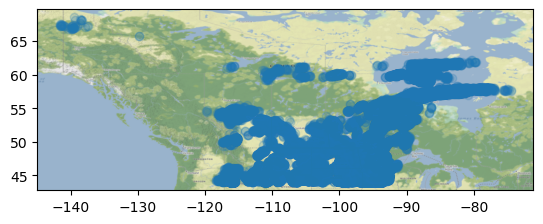

In [7]:
smol = get_ca_lt("20230530")
plot_ca(smol)

In [4]:
date_range = pd.date_range(start = "2023-05-01 12:00:00", end = "2023-07-01 00:00:00", freq="24H")

date_snap = date_range.strftime("%Y%m%d")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d")

20230525


/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


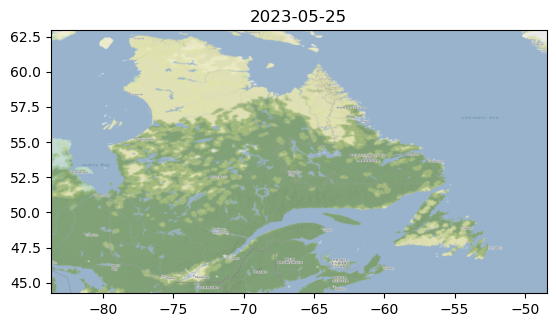

20230526


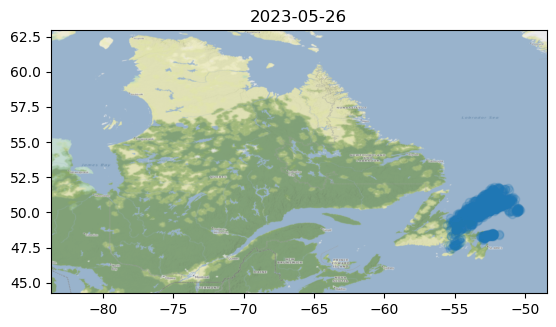

20230527


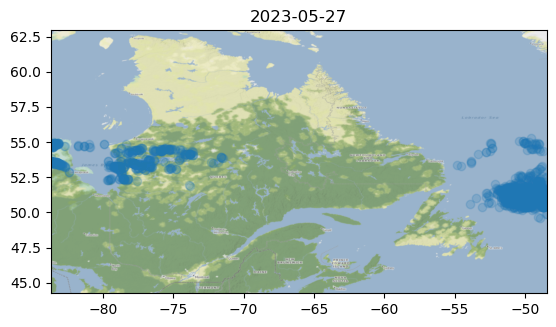

20230528


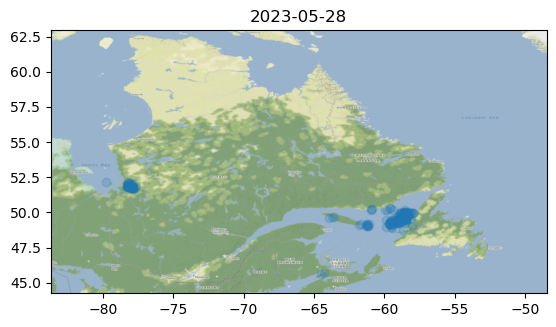

20230529


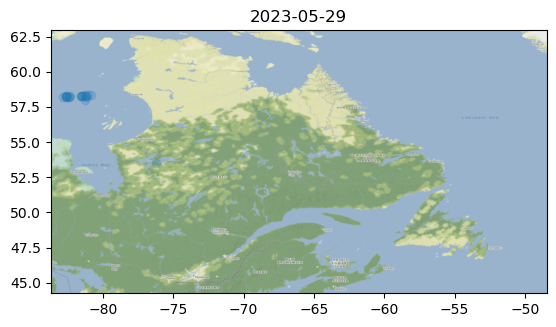

20230530


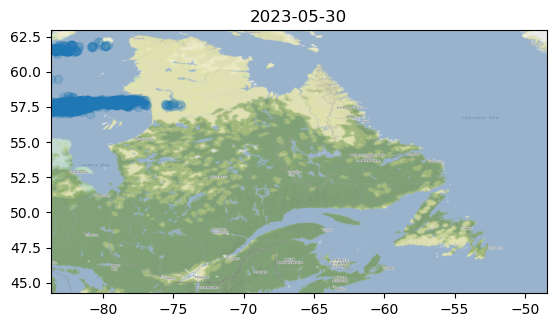

20230531


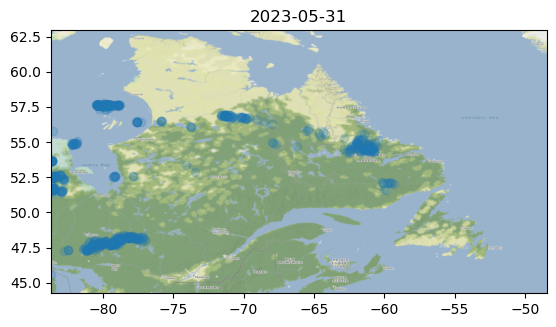

In [26]:
# for d,n in zip(date_snap,nice_dates) :
#     print(d)
#     bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
#     smol = get_ca_lt(str(d), bbox  = bbox)
#     plot_ca(smol, title = n, bbox = bbox)
    

In [17]:
## Make an overall lightning timing
import time
from datetime import date
import traceback

def lt_timeseries_extract(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt(str(i), bbox = bbox )

        except Exception as e:
            print("Error at date: ",n,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        lt.append(smol)
        if((n%5 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(pd.concat(lt, ignore_index=True), crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + ".csv")
        
    return(manyfr)

In [18]:
date_range = pd.date_range(start = "2023-06-11 00:00:00", end = "2023-07-01 00:00:00", freq="24H")

date_snap = date_range.strftime("%Y%m%d")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d")

In [ ]:
# Grab Currrent Time Before Running the Code
start = time.time()

################# Horrible for loop ##################
sub_region = "Quebec"
region =  "CA"
#year = "2023"
run_name_st = "base_stats"
manyfr = lt_timeseries_extract(date_snap = date_snap, region = region,  sub_region = sub_region, run_name = run_name_st) ## putting into function because might help memory???

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))


Error at date:  3
Traceback (most recent call last):
  File "/tmp/ipykernel_2424/1377027384.py", line 15, in lt_timeseries_extract
    smol = get_ca_lt(str(i), bbox = bbox )
  File "/tmp/ipykernel_2424/2253449646.py", line 4, in get_ca_lt
    lt = pd.read_csv("/projects/2023_lightning_data/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 950, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/io/parsers/readers.py", line 605, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/

In [5]:
manyfr = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-09-26base_stats.csv")

manyfr = gpd.GeoDataFrame(manyfr)

manyfr.t = manyfr.t.astype("datetime64[ns]")

In [20]:
#n_strike = manyfr.groupby("t").count()

In [37]:
#manyfr

In [6]:
import time
from datetime import date

am = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
pm = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]



manyfr["day"] = manyfr.t.dt.day
manyfr["hour"] = manyfr.t.dt.hour
manyfr["is_am"] = manyfr.hour.isin(am)
manyfr["t_agg"] = manyfr.t.dt.strftime("%Y-%m-%d %H:00:00")
manyfr.t = manyfr.t.dt.tz_localize("UTC")


In [70]:
manyfr.t.dt.tz_localize("UTC")

0      2023-05-01 20:00:19.230000+00:00
1      2023-05-01 18:18:05.635000+00:00
2      2023-05-01 18:22:48.345000+00:00
3      2023-05-01 18:43:15.239000+00:00
4      2023-05-01 22:51:54.848000+00:00
                     ...               
3825   2023-05-15 11:44:26.923000+00:00
3826   2023-05-15 11:44:26.889000+00:00
3827   2023-05-16 09:18:50.994000+00:00
3828   2023-05-16 09:11:20.200000+00:00
3829   2023-05-16 09:11:20.309000+00:00
Name: t, Length: 3830, dtype: datetime64[ns, UTC]

In [24]:
#n_strike.hour.unique()

In [7]:
day_strike = manyfr.groupby('t_agg').count()
#day_strike["t"] = day_strike.index
day_strike.index

Index(['2023-05-01 07:00:00', '2023-05-01 16:00:00', '2023-05-01 18:00:00',
       '2023-05-01 20:00:00', '2023-05-01 22:00:00', '2023-05-01 23:00:00',
       '2023-05-02 15:00:00', '2023-05-02 16:00:00', '2023-05-02 17:00:00',
       '2023-05-02 18:00:00',
       ...
       '2023-06-10 14:00:00', '2023-06-10 15:00:00', '2023-06-10 16:00:00',
       '2023-06-10 17:00:00', '2023-06-10 18:00:00', '2023-06-10 19:00:00',
       '2023-06-10 20:00:00', '2023-06-10 21:00:00', '2023-06-10 22:00:00',
       '2023-06-10 23:00:00'],
      dtype='object', name='t_agg', length=283)

2023-06-10 23:00:00


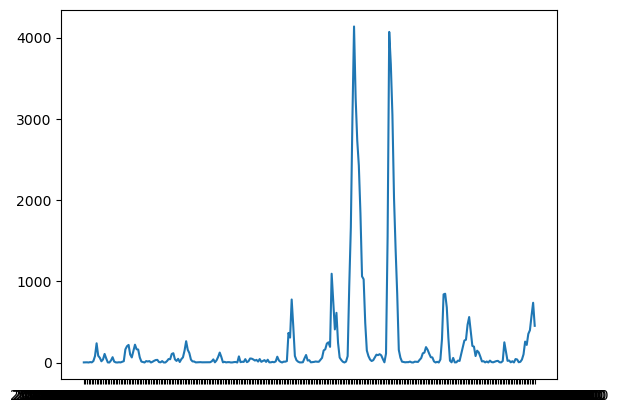

In [9]:
plt.plot(day_strike.index, day_strike.InterCloud)
print(max(day_strike.index))

In [10]:
### Get the station data

st = pd.read_csv("/projects/old_shared/Quebec_fwi_viz/718270-99999.linear.DailyFWIfromHourlyInterp.csv") ## Corrected record from Robert
#st = st[0:9672] # Cut out extra excel cells
st['HH'] = '12'
st.YYYY = st.YYYY.astype("int")
st.MM = st.MM.astype("int")
st.DD = st.DD.astype("int")
st = fv.date_convert(st)

st['MM_DD'] = st['time'].apply(lambda x: x.strftime('%m-%d'))

#st['ismayjune'] = np.logical_or((st.MM == 6), (st.MM == 5))
st['ismayjune'] = st.MM.isin([5, 6, 7]) # Is May, June or July? 
mj = st[st['ismayjune'] == True]
mj = mj.set_index("time")
#st = st.set_index("time")

mj = mj[mj.index > "1991-01-01 00:00:00"]
mj = mj[mj.index < "2020-12-31 23:00:00"]

#
mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()

dates = ("2023-" + mean_quant.index.get_level_values(level=1).astype("str") + "-" + mean_quant.index.get_level_values(level=0).astype("str"))

mean_quant["dates"] = pd.to_datetime(dates)
mean_quant = mean_quant.sort_values(by = "dates")
mean_quant.set_index("dates", inplace = True)


upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
upper["dates"] = pd.to_datetime(dates)
upper = upper.sort_values(by = "dates")
upper.set_index("dates", inplace = True)

lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.025)
lower["dates"] = pd.to_datetime(dates)
lower = lower.sort_values(by = "dates")
lower.set_index("dates", inplace = True)


mid_lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.25)
mid_lower["dates"] = pd.to_datetime(dates)
mid_lower = mid_lower.sort_values(by = "dates")
mid_lower.set_index("dates", inplace = True)


mid_upper = mj.groupby([mj.index.day, mj.index.month]).quantile(0.75)
mid_upper["dates"] = pd.to_datetime(dates)
mid_upper = mid_upper.sort_values(by = "dates")
mid_upper.set_index("dates", inplace = True)


date_range = pd.date_range(start = "2023-05-01 12:00:00", end = "2023-07-01 12:00:00", freq="12H")
#date_range_format = datetime.strptime(date_rage, 
date_snap = date_range.strftime("%Y%m%d%p")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d %p")


#### To generate fire stats
# snap_list = []
# for d,n in zip(date_snap, date_range):
#     #print(n)
#     snap = fv.prep_gdf(date = d,layer='perimeter',handle_multi=False,only_lf=False,area_lim=3.7, year = "2023", path_region = "QuebecGlobalNRT_tess")
#     farea = sum(snap.farea)
#     numfires = len(snap.mergeid.unique())
#     num_active_fires = len(snap[snap.n_newpixels > 0])
#     tot_frp = sum(snap.meanFRP)
#     mean_frp = snap.meanFRP.mean()
    
#     snap_list.append([n, farea, numfires, num_active_fires, tot_frp, mean_frp])
    

#     #snap = snap[snap.t ]
# fire_stats = pd.DataFrame(data = snap_list, columns = ["t", "farea", "numfires", "num_active_fires",  "tot_frp", "mean_frp"])
# fire_stats.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/exp_Quebec_firestats.csv")

In [4]:
fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/exp_Quebec_firestats.csv")

In [5]:
fire_stats

,Unnamed: 0,t,farea,numfires,num_active_fires,tot_frp,mean_frp
0,0,2023-05-01 12:00:00,36.664585,124,0,0.000000,0.000000
1,1,2023-05-02 00:00:00,36.215426,125,5,9.775000,0.078200
2,2,2023-05-02 12:00:00,36.215426,125,0,0.000000,0.000000
3,3,2023-05-03 00:00:00,34.839780,118,1,1.680000,0.014237
4,4,2023-05-03 12:00:00,33.931420,115,1,4.750000,0.041304
...,...,...,...,...,...,...,...
118,118,2023-06-29 12:00:00,31142.526738,240,28,341.656860,1.423570
119,119,2023-06-30 00:00:00,31360.743642,236,26,40.289081,0.170716
120,120,2023-06-30 12:00:00,31296.647160,232,16,153.539702,0.661809
121,121,2023-07-01 00:00:00,32178.684549,230,16,28.851997,0.125443


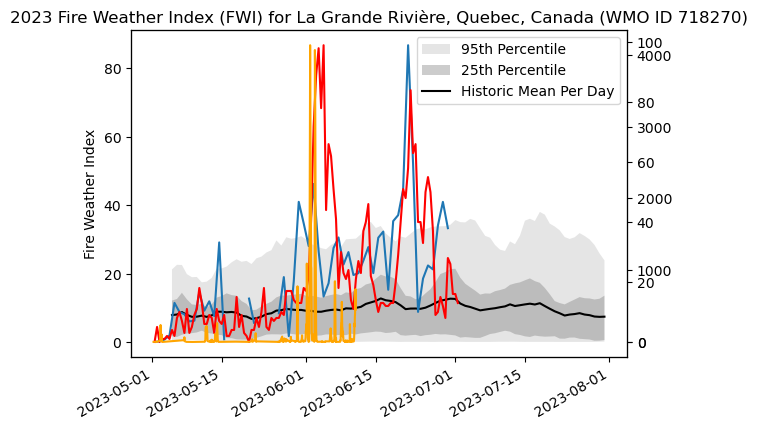

In [11]:
#plt.plot(day_strike.index, day_strike.InterCloud)
fig, ax = plt.subplots()
ax.fill_between(upper.index, upper.FWI.rolling(5).mean(), lower.FWI.rolling(5).mean(), 
                facecolor='grey', 
                alpha=0.2,
                label= "95th Percentile")
ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(5).mean(), mid_lower.FWI.rolling(5).mean(), 
                facecolor='grey', 
                alpha=0.4,
                label= "25th Percentile")
ax.plot(mean_quant.index, mean_quant.FWI.rolling(5).mean(), 
        color = "black",
        label= "Historic Mean Per Day")
ax.plot(st[(st.time >= "2023-05-01")].time.astype('datetime64[ns]'), st[(st.time >= "2023-05-01")].FWI)
ax.set_ylabel("Fire Weather Index")
ax.set_title("2023 Fire Weather Index (FWI) for La Grande Rivière, Quebec, Canada (WMO ID 718270)")
ax.legend()
ax2 = ax.twinx()
ax2.plot(fire_stats.t, fire_stats.num_active_fires, color = "red", label = "Number of Fires in Quebec")
#ax2.legend(loc = 0.5)
ax3 = ax.twinx()
ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")
fig.autofmt_xdate()

#plt.plot(day_strike.index, day_strike.InterCloud)

In [13]:
max(day_strike.index.astype("datetime64[ns]"))

Timestamp('2023-06-10 23:00:00')

In [78]:
day_strike.index.astype("datetime64[ns]")

DatetimeIndex(['2023-05-01 07:00:00', '2023-05-01 16:00:00',
               '2023-05-01 18:00:00', '2023-05-01 20:00:00',
               '2023-05-01 22:00:00', '2023-05-01 23:00:00',
               '2023-05-02 15:00:00', '2023-05-02 16:00:00',
               '2023-05-02 17:00:00', '2023-05-02 18:00:00',
               '2023-05-02 19:00:00', '2023-05-02 20:00:00',
               '2023-05-02 21:00:00', '2023-05-02 22:00:00',
               '2023-05-02 23:00:00', '2023-05-03 00:00:00',
               '2023-05-03 02:00:00', '2023-05-07 11:00:00',
               '2023-05-07 12:00:00', '2023-05-07 13:00:00',
               '2023-05-07 22:00:00', '2023-05-09 04:00:00',
               '2023-05-11 13:00:00', '2023-05-11 14:00:00',
               '2023-05-11 15:00:00', '2023-05-11 17:00:00',
               '2023-05-11 18:00:00', '2023-05-11 19:00:00',
               '2023-05-11 20:00:00', '2023-05-11 21:00:00',
               '2023-05-11 22:00:00', '2023-05-11 23:00:00',
               '2023-05-